In [58]:
import tensorflow as tf
import pandas as pd
print(tf.__version__)

2.8.2


In [59]:
%ls drive/MyDrive/Colab\ Notebooks/Mutt

ls: cannot access 'drive/MyDrive/Colab Notebooks/Mutt': No such file or directory


In [60]:
%cd drive/MyDrive/Colab\ Notebooks/Mutt

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/Mutt'
/content/drive/MyDrive/Colab Notebooks/Mutt


In [84]:
df = pd.read_excel('bitcoin.xlsx', usecols= ['date','price'])
#df.sort_values(by=['date'])
df.shape

(97, 2)

In [86]:
df.set_index('date', inplace=True)


In [87]:
df.head(30)

,price
date,
2022-05-02,38537.654767
2022-05-03,38561.565399
2022-06-01,31865.749621
2022-07-05,20257.012329
2022-07-06,20188.779664
2022-07-07,20566.687224
2022-07-08,21660.596837
2022-07-09,21858.818749
2022-07-10,21589.628101


In [88]:
df = df.sort_values(by=['date'])
df

,price
date,
2022-05-01,37820.611765
2022-05-02,38537.654767
2022-05-03,38561.565399
2022-05-04,37758.496108
2022-05-05,39699.024041
...,...
2022-08-01,23379.700525
2022-08-02,23333.749243
2022-08-03,23053.846847


In [79]:
df.set_index('date', inplace=True)

In [89]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [90]:
time=df.index
series=df.price

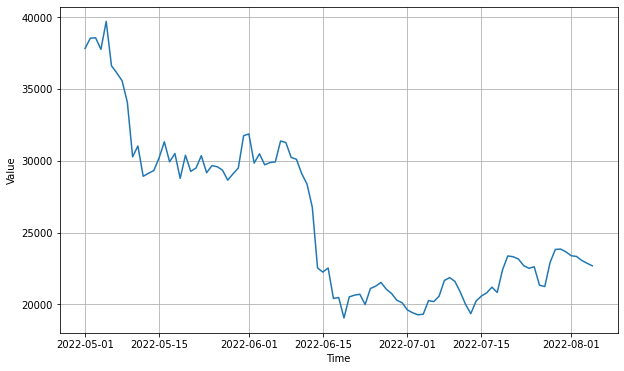

In [91]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [109]:
split_time=80
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 7
batch_size = 10
shuffle_buffer_size = 1000

In [110]:
def windowed_dataset (series,window_size,batch_size,shuffle_buffer_size):
  ds = tf.expand_dims(series,axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(ds)
  ds = ds.window(size=window_size,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer_size)
  ds = ds.map(lambda w: (w[:-1],w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [111]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [112]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 7
batch_size = 10
train_set = windowed_dataset(x_train,window_size=window_size,batch_size=batch_size,shuffle_buffer_size=shuffle_buffer_size)

In [114]:
model = tf.keras.Sequential([
                     tf.keras.layers.Conv1D(filters=7,
                                            kernel_size=5,
                                            strides=1,
                                            activation='relu',
                                            padding='causal',
                                            input_shape=[None,1]
                     ),
                     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(7,return_sequences=True)),
                     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12,return_sequences=True)),
                     #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
                     #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True)),
                     #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,return_sequences=True)),
                     tf.keras.layers.Dense(12,activation='relu'),
                     tf.keras.layers.Dense(10,activation='relu'),
                     tf.keras.layers.Dense(1)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/10))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mape']
)


In [115]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 7)           42        
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 14)         840       
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 24)         2592      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, None, 12)          300       
                                                                 
 dense_4 (Dense)             (None, None, 10)          130       
                                                                 
 dense_5 (Dense)             (None, None, 1)          

In [116]:
history = model.fit(train_set,
                    epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 59s 14ms/step - loss: 26173.9707 - mape: 99.9994 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 26173.9727 - mape: 99.9994 - lr: 1.2589e-08
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 26173.9746 - mape: 99.9994 - lr: 1.5849e-08
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 26173.9746 - mape: 99.9994 - lr: 1.9953e-08
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 26173.9727 - mape: 99.9994 - lr: 2.5119e-08
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 26173.9746 - mape: 99.9994 - lr: 3.1623e-08
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 26173.9746 - mape: 99.9994 - lr: 3.9811e-08
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 26173.9727 - mape: 99.9994 - lr: 5.0119e-08
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss:

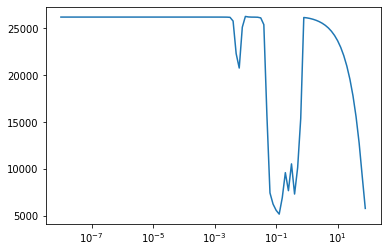

In [117]:
plt.semilogx(history.history['lr'],history.history['loss'])

In [118]:
#checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,monitor='mape',restore_best_weights=True)

In [119]:
model = tf.keras.Sequential([
                     tf.keras.layers.Conv1D(filters=7,
                                            kernel_size=5,
                                            strides=1,
                                            activation='relu',
                                            padding='causal',
                                            input_shape=[None,1]
                     ),
                     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(7,return_sequences=True)),
                     #tf.keras.layers.Dropout(0.2),
                     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12,return_sequences=True)),
                     #tf.keras.layers.Dropout(0.2),
                     #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
                     #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True)),
                     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12,return_sequences=True)),
                     #tf.keras.layers.Dense(256,activation='relu'),
                     #tf.keras.layers.Dropout(0.2),
                     #tf.keras.layers.Dense(10,activation='relu'),
                     #tf.keras.layers.Dropout(0.4),
                     tf.keras.layers.Dense(1)
                     #,tf.keras.layers.Lambda(lambda x: x * 200)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mape']
)
history = model.fit(train_set,
                    #validation_data = 
                    callbacks=[early_stopping],
                    epochs=500
                    )

Epoch 1/500
8/8 [==============================] - 10s 17ms/step - loss: 26172.5332 - mape: 99.9937
Epoch 2/500
8/8 [==============================] - 0s 14ms/step - loss: 26157.6270 - mape: 99.9344
Epoch 3/500
8/8 [==============================] - 0s 14ms/step - loss: 26093.4766 - mape: 99.6745
Epoch 4/500
8/8 [==============================] - 0s 14ms/step - loss: 25973.7637 - mape: 99.2052
Epoch 5/500
8/8 [==============================] - 0s 14ms/step - loss: 25820.2715 - mape: 98.5916
Epoch 6/500
8/8 [==============================] - 0s 15ms/step - loss: 25650.4258 - mape: 97.9100
Epoch 7/500
8/8 [==============================] - 0s 14ms/step - loss: 25473.4043 - mape: 97.2175
Epoch 8/500
8/8 [==============================] - 0s 14ms/step - loss: 25293.2793 - mape: 96.4902
Epoch 9/500
8/8 [==============================] - 0s 14ms/step - loss: 25111.8086 - mape: 95.7644
Epoch 10/500
8/8 [==============================] - 0s 14ms/step - loss: 24929.7637 - mape: 95.0390
Epoch 11

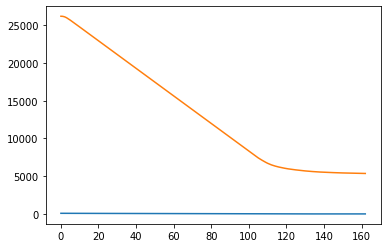

In [120]:
mae = history.history['mape']
loss = history.history['loss']
plt.plot(mae)
plt.plot(loss)

In [121]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(10).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [122]:
series

date
2022-05-01    37820.611765
2022-05-02    38537.654767
2022-05-03    38561.565399
2022-05-04    37758.496108
2022-05-05    39699.024041
                  ...     
2022-08-01    23379.700525
2022-08-02    23333.749243
2022-08-03    23053.846847
2022-08-04    22860.420984
2022-08-05    22678.363634
Name: price, Length: 97, dtype: float64

In [123]:
rnn_forecast = model_forecast(model, series, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

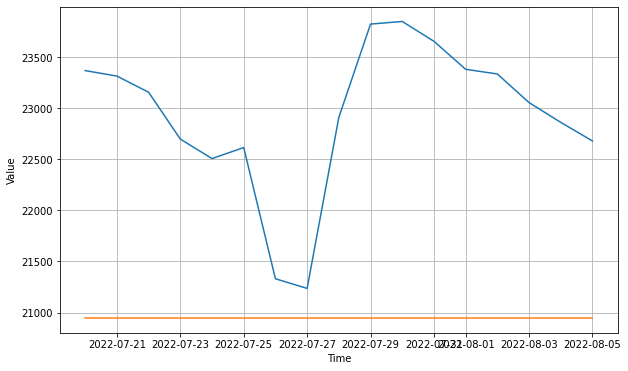

In [124]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)